# 1. Imports

In [89]:
import cv2
import os
import json
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F
from torchvision.transforms import transforms as transforms

# Library for augmentations
import albumentations as A

# https://github.com/pytorch/vision/tree/main/references/detection
import transforms, utils, engine, train
from utils import collate_fn
from engine import train_one_epoch, evaluate

# 2. Augmentations

In [2]:
def train_transform(rotate: bool=True):
    funcs = []
    
    # Random change of brightness and contrast
    funcs.append(A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, brightness_by_max=True, always_apply=False, p=1))
    
    if rotate:
        # Random rotation
        funcs.append(A.augmentations.geometric.rotate.Rotate(limit=10, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=1))
    
        ret = A.Compose([A.Sequential(funcs, p=1)], keypoint_params=A.KeypointParams(format='xy'),
              bbox_params=A.BboxParams(format='pascal_voc', label_fields=['bboxes_labels']))
    
    else:
        ret = A.Compose([A.Sequential(funcs, p=1)], )
    
    return ret

# 3. Dataset class

In [3]:
class ClassDataset(Dataset):
    def __init__(self, images: list, annotations: list, transform=None, demo=False, filenames=None):                
        #self.root = root
        self.transform = transform
        # Use demo=True if you need transformed and original images (visualization purposes)
        self.demo = demo
        self.images = images
        self.annotations = annotations
        # If filenames are set, it will be printed when image is accessed (logging purposes)
        self.filenames = filenames
    
    def __getitem__(self, idx):
        img_original = self.images[idx]
        bboxes_original = self.annotations[idx]['bboxes']
        keypoints_original = self.annotations[idx]['keypoints']
        bboxes_labels_original = ['Car wheel' for _ in bboxes_original]           

        if self.transform:   
            # Converting keypoints from [x, y, visibility]-format to [x, y]-format + Flattening nested list of keypoints 
            keypoints_original_flattened = [el[0:2] for kp in keypoints_original for el in kp]

            # Apply augmentations (while loop to retry different rotation if a rotation crops away a keypoint)
            keypoints = []
            while len(keypoints) != len(keypoints_original_flattened):
                transform = self.transform(rotate=True)
                # Try-except block because some bboxes get mangled in the transformation process (negative width or height)
                try:
                    transformed = transform(image=img_original, bboxes=bboxes_original, bboxes_labels=bboxes_labels_original, keypoints=keypoints_original_flattened)
                except ValueError:
                    transform = self.transform(rotate=False)
                    transformed = transform(image=img_original)
                    transformed['bboxes'] = bboxes_original
                    transformed['keypoints'] = keypoints_original_flattened

                img = transformed['image']
                bboxes = transformed['bboxes']
                keypoints = transformed['keypoints']
            
            if self.filenames:
                print(self.filenames[idx])
            
            # Unflattening [[x, y], [x, y], ...] keypoints into [[[x, y], [x, y], [x, y], [x, y], [x, y]], [...], [...]]
            keypoints_transformed_unflattened = np.reshape(np.array(keypoints), (-1, 5, 2)).tolist()

            # Converting transformed keypoints from [x, y]-format to [x, y, visibility]-format by appending original visibilities to transformed coordinates of keypoints
            keypoints = []
            for o_idx, obj in enumerate(keypoints_transformed_unflattened):
                obj_keypoints = []
                for k_idx, kp in enumerate(obj): # Iterating over keypoints in each object
                    # kp - coordinates of keypoint
                    # keypoints_original[o_idx][k_idx][2] - original visibility of keypoint
                    obj_keypoints.append(kp + [keypoints_original[o_idx][k_idx][2]])
                keypoints.append(obj_keypoints)
                
        # No transformation
        else:
            img, bboxes, keypoints = img_original, bboxes_original, keypoints_original        
        
        # Convert everything into a torch tensor        
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)       
        target = {}
        target['boxes'] = bboxes
        # All objects are car wheels
        target['labels'] = torch.as_tensor([1 for _ in bboxes], dtype=torch.int64)
        target['image_id'] = torch.tensor([idx])
        target['area'] = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        target['iscrowd'] = torch.zeros(len(bboxes), dtype=torch.int64)
        target['keypoints'] = torch.as_tensor(keypoints, dtype=torch.float32)        
        img = F.to_tensor(img)
        
        bboxes_original = torch.as_tensor(bboxes_original, dtype=torch.float32)
        target_original = {}
        target_original['boxes'] = bboxes_original
        # All objects are car wheels
        target_original['labels'] = torch.as_tensor([1 for _ in bboxes_original], dtype=torch.int64)
        target_original['image_id'] = torch.tensor([idx])
        target_original['area'] = (bboxes_original[:, 3] - bboxes_original[:, 1]) * (bboxes_original[:, 2] - bboxes_original[:, 0])
        target_original['iscrowd'] = torch.zeros(len(bboxes_original), dtype=torch.int64)
        target_original['keypoints'] = torch.as_tensor(keypoints_original, dtype=torch.float32)        
        img_original = F.to_tensor(img_original)

        if self.demo:
            return img, target, img_original, target_original
        else:
            return img, target
    
    def __len__(self):
        return len(self.images)

# 4. Visualizing a random item from dataset

In [85]:
keypoints_classes_ids2names = {0: 'T', 1: 'B', 2: 'R', 3: 'S', 4: 'W'}

def visualize(image, bboxes, keypoints, image_original=None, bboxes_original=None, keypoints_original=None):
    fontsize = 18
    
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    if image_original is not None:
        image_original = cv2.cvtColor(image_original, cv2.COLOR_GRAY2RGB)

    for bbox in bboxes:
        start_point = (bbox[0], bbox[1])
        end_point = (bbox[2], bbox[3])
        image = cv2.rectangle(image.copy(), start_point, end_point, (0, 255, 255), 2)
    
    for kps in keypoints:
        for idx, kp in enumerate(kps):
            image = cv2.circle(image.copy(), tuple(kp), 5, (255, 128, 0), 10)
            image = cv2.putText(image.copy(), ' ' + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 128, 0), 3, cv2.LINE_AA)

    if image_original is None and keypoints_original is None:
        plt.figure(figsize=(40, 40))
        plt.imshow(image)

    else:
        for bbox in bboxes_original:
            start_point = (bbox[0], bbox[1])
            end_point = (bbox[2], bbox[3])
            image_original = cv2.rectangle(image_original.copy(), start_point, end_point, (0, 255, 255), 2)
        
        for kps in keypoints_original:
            for idx, kp in enumerate(kps):
                image_original = cv2.circle(image_original, tuple(kp), 5, (255, 128, 0), 10)
                image_original = cv2.putText(image_original, ' ' + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 128, 0), 3, cv2.LINE_AA)

        f, ax = plt.subplots(1, 2, figsize=(40, 20))

        ax[0].imshow(image_original)
        ax[0].set_title('Original image', fontsize=fontsize)

        ax[1].imshow(image)
        ax[1].set_title('Transformed image', fontsize=fontsize)

In [5]:
def load_dataset():

    path_to_images = 'dataset/images'
    path_to_annotations = 'dataset/annotations'

    image_filenames = sorted(os.listdir(path_to_images))
    images = [cv2.imread(os.path.join(path_to_images, file), cv2.IMREAD_GRAYSCALE) for file in image_filenames]

    annotation_filenames = sorted(os.listdir(path_to_annotations))
    annotations = []
    for file in annotation_filenames:
        with open(os.path.join(path_to_annotations, file), 'r') as annotation:
            annotations.append(json.load(annotation))
    
    return images, annotations, image_filenames

1_004.jpg


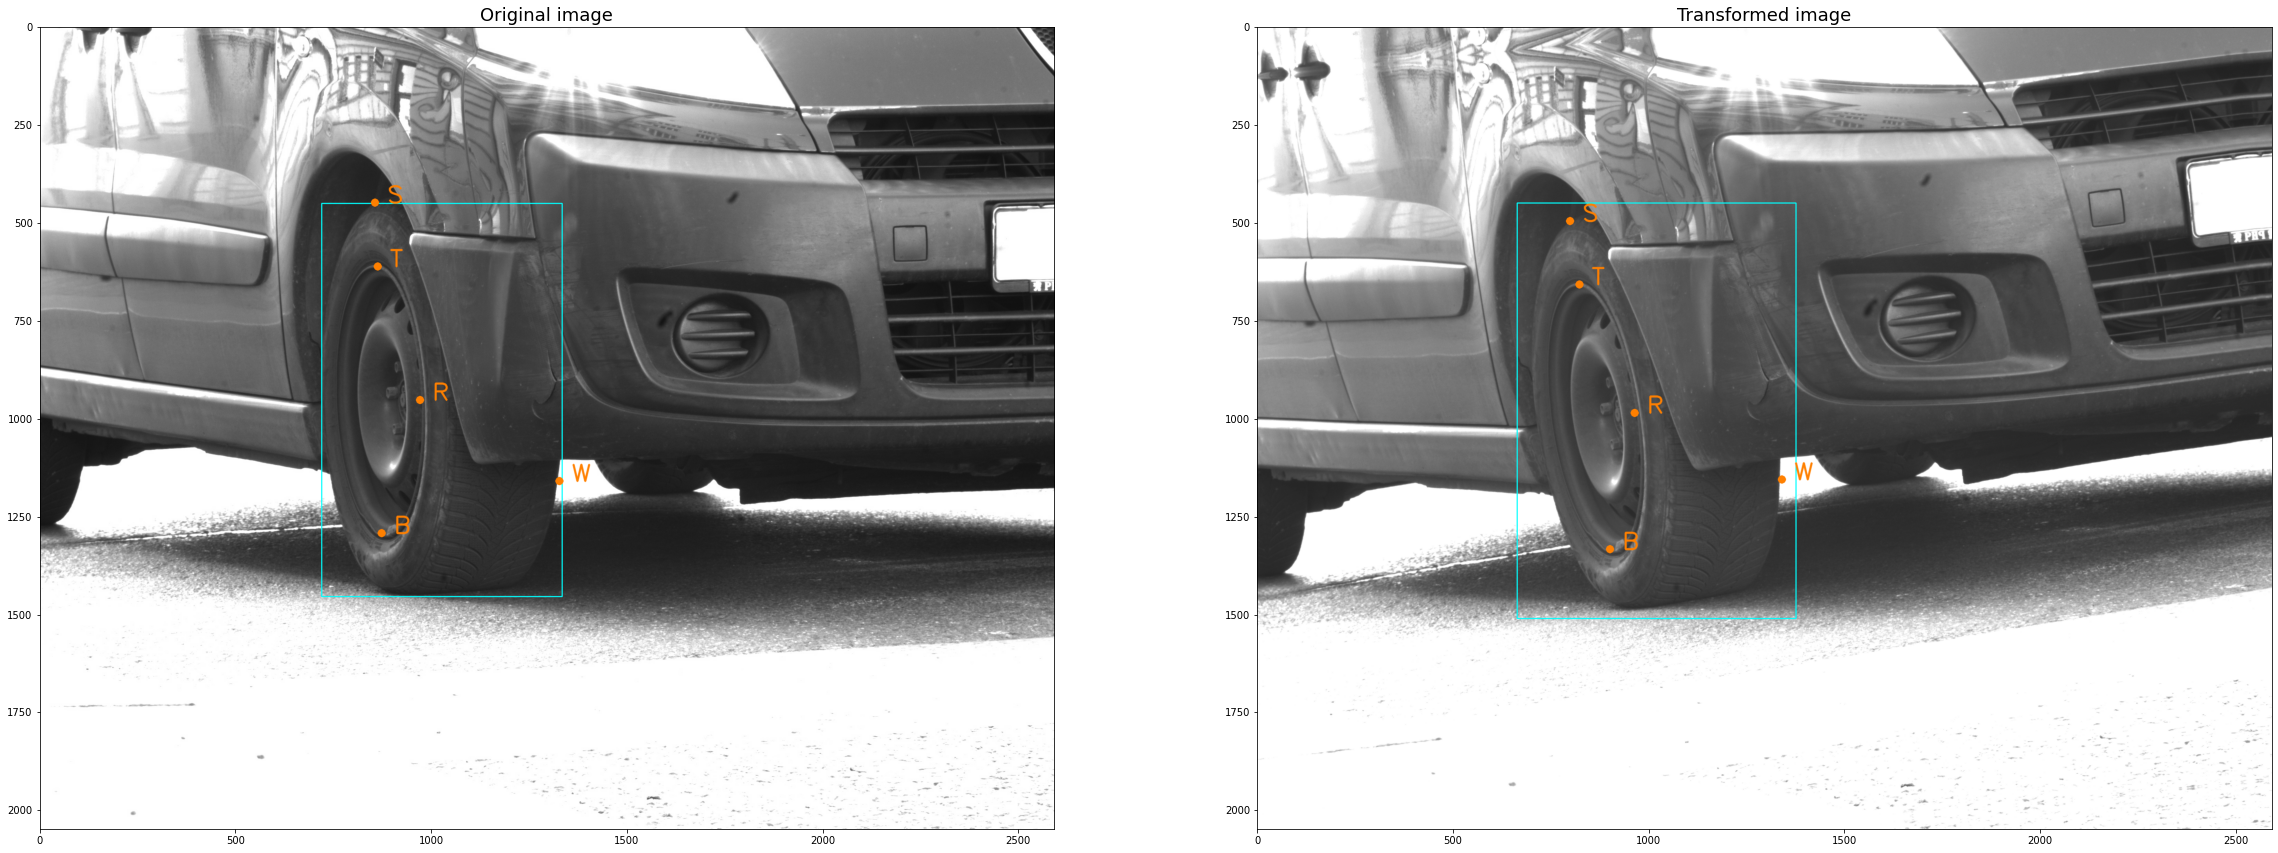

In [86]:
images, annotations, filenames = load_dataset()

dataset = ClassDataset(images, annotations, transform=train_transform, demo=True, filenames=filenames)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

iterator = iter(data_loader)
batch = next(iterator)

image = (batch[0][0].permute(1, 2, 0).numpy() * 255).astype(np.uint8)
bboxes = batch[1][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints = []
for kps in batch[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints.append([kp[:2] for kp in kps])

image_original = (batch[2][0].permute(1, 2, 0).numpy() * 255).astype(np.uint8)
bboxes_original = batch[3][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints_original = []
for kps in batch[3][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints_original.append([kp[:2] for kp in kps])

visualize(image, bboxes, keypoints, image_original, bboxes_original, keypoints_original)

# 5. Training

In [7]:
def get_model(num_keypoints, weights_path=None):
    # Aspect ratio = width / height
    # We know that car tires will always fit in: 1 <= aspect ratio <= 2 
    # Though upper bound depends on minimum angle of attack, which on this dataset is something like 20 degrees
    # Basically the tire will never be captured from the front anyway, in which case the aspect ratio might be something like 3
    anchor_generator = AnchorGenerator(sizes=(100, 250, 400, 650, 800), 
                                       aspect_ratios=(1.0, 1.25, 1.5, 1.75, 2.0))
    model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False,
                                                                   pretrained_backbone=True,
                                                                   num_keypoints=num_keypoints,
                                                                   # One class for car wheel, one class for background
                                                                   num_classes=2,
                                                                   rpn_anchor_generator=anchor_generator)
    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)        
        
    return model

In [8]:
def test_train_split_indexes(dataset_length: int, train_size: float=0.8, seed: int=None):
    """
    Split indexes of array into train/test
    
    [0, 1, 2, 3, 4, 5] => [0, 2, 3, 5], [1, 4]
    """
    
    if not 0 < train_size <= 1:
        raise ValueError('Invalid train size (must be between 0 and 1, 80/20 would be 0.8 train_size,)')
    
    if seed is not None:
        np.random.seed(seed)
        
    indexes = np.indices([dataset_length])[0]
    np.random.shuffle(indexes)
    np.random.seed()
    
    train_size = int(round(dataset_length * train_size, 0))
    train_indexes = indexes[:train_size]
    test_indexes = indexes[train_size:]
    train_indexes.sort()
    test_indexes.sort()
    
    return train_indexes.tolist(), test_indexes.tolist()

def test_train_split(dataset: list, train_size: float=0.8, seed: int=None):
    """Split dataset into training and testing datasets"""
    
    train_indexes, test_indexes = test_train_split_indexes(len(dataset), train_size, seed)
    
    train = []
    test = []
    
    for train_index in train_indexes:
        train.append(dataset[train_index])
    for test_index in test_indexes:
        test.append(dataset[test_index])
        
    return train, test

# Load dataset
images, annotations, filenames = load_dataset()

# Split into train and test datasets with 66/34 split
seed = 666
train_size = 0.66
train_images, test_images = test_train_split(images, train_size, seed)
train_annotations, test_annotations = test_train_split(annotations, train_size, seed)
train_filenames, test_filenames = test_train_split(filenames, train_size, seed)

In [9]:
# Create objects used by PyTorch, add transformation function to train data (artificial diversity)
dataset_train = ClassDataset(train_images, train_annotations, transform=train_transform, demo=False)
dataset_test = ClassDataset(test_images, test_annotations, transform=None, demo=False)

data_loader_train = DataLoader(dataset_train, batch_size=1, shuffle=True, collate_fn=collate_fn)
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

# Prepare model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = get_model(num_keypoints=5)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)
num_epochs = 50

# Training
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=100)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device)
    
# Save model after training
torch.save(model.state_dict(), 'saved_model.pth')

/home/daniel/.local/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [  0/100]  eta: 0:00:59  lr: 0.000011  loss: 9.7059 (9.7059)  loss_classifier: 0.6630 (0.6630)  loss_box_reg: 0.0894 (0.0894)  loss_keypoint: 8.1017 (8.1017)  loss_objectness: 0.6935 (0.6935)  loss_rpn_box_reg: 0.1583 (0.1583)  time: 0.5967  data: 0.0504  max mem: 1135
Epoch: [0]  [ 99/100]  eta: 0:00:00  lr: 0.001000  loss: 6.4793 (7.8714)  loss_classifier: 0.1941 (0.3126)  loss_box_reg: 0.2500 (0.1482)  loss_keypoint: 5.5367 (6.6546)  loss_objectness: 0.3919 (0.5921)  loss_rpn_box_reg: 0.1400 (0.1639)  time: 0.2512  data: 0.0222  max mem: 1641
Epoch: [0] Total time: 0:00:22 (0.2262 s / it)
creating index...
index created!
Test:  [ 0/51]  eta: 0:00:06  model_time: 0.1050 (0.1050)  evaluator_time: 0.0043 (0.0043)  time: 0.1255  data: 0.0128  max mem: 1641
Test:  [50/51]  eta: 0:00:00  model_time: 0.0910 (0.0915)  evaluator_time: 0.0040 (0.0042)  time: 0.1095  data: 0.0118  max mem: 1641
Test: Total time: 0:00:05 (0.1135 s / it)
Averaged stats: model_time: 0.0910 (0.0915)  e

Epoch: [3]  [  0/100]  eta: 0:00:24  lr: 0.001000  loss: 3.6608 (3.6608)  loss_classifier: 0.0599 (0.0599)  loss_box_reg: 0.0820 (0.0820)  loss_keypoint: 3.4044 (3.4044)  loss_objectness: 0.0514 (0.0514)  loss_rpn_box_reg: 0.0630 (0.0630)  time: 0.2429  data: 0.0209  max mem: 1698
Epoch: [3]  [ 99/100]  eta: 0:00:00  lr: 0.001000  loss: 4.2109 (4.2031)  loss_classifier: 0.0849 (0.0851)  loss_box_reg: 0.1358 (0.1208)  loss_keypoint: 3.7295 (3.8230)  loss_objectness: 0.0629 (0.0697)  loss_rpn_box_reg: 0.0928 (0.1044)  time: 0.2500  data: 0.0184  max mem: 1698
Epoch: [3] Total time: 0:00:24 (0.2480 s / it)
creating index...
index created!
Test:  [ 0/51]  eta: 0:00:05  model_time: 0.0820 (0.0820)  evaluator_time: 0.0017 (0.0017)  time: 0.1004  data: 0.0132  max mem: 1698
Test:  [50/51]  eta: 0:00:00  model_time: 0.0785 (0.0787)  evaluator_time: 0.0021 (0.0022)  time: 0.0961  data: 0.0120  max mem: 1698
Test: Total time: 0:00:04 (0.0979 s / it)
Averaged stats: model_time: 0.0785 (0.0787)  e

Epoch: [6]  [  0/100]  eta: 0:00:24  lr: 0.000300  loss: 3.7649 (3.7649)  loss_classifier: 0.0233 (0.0233)  loss_box_reg: 0.0333 (0.0333)  loss_keypoint: 3.6244 (3.6244)  loss_objectness: 0.0315 (0.0315)  loss_rpn_box_reg: 0.0523 (0.0523)  time: 0.2417  data: 0.0226  max mem: 1698
Epoch: [6]  [ 99/100]  eta: 0:00:00  lr: 0.000300  loss: 2.8395 (3.1544)  loss_classifier: 0.0371 (0.0528)  loss_box_reg: 0.0563 (0.0758)  loss_keypoint: 2.6636 (2.9193)  loss_objectness: 0.0231 (0.0352)  loss_rpn_box_reg: 0.0581 (0.0715)  time: 0.2477  data: 0.0217  max mem: 1698
Epoch: [6] Total time: 0:00:25 (0.2525 s / it)
creating index...
index created!
Test:  [ 0/51]  eta: 0:00:04  model_time: 0.0761 (0.0761)  evaluator_time: 0.0012 (0.0012)  time: 0.0949  data: 0.0141  max mem: 1698
Test:  [50/51]  eta: 0:00:00  model_time: 0.0765 (0.0759)  evaluator_time: 0.0017 (0.0017)  time: 0.0957  data: 0.0141  max mem: 1698
Test: Total time: 0:00:04 (0.0950 s / it)
Averaged stats: model_time: 0.0765 (0.0759)  e

Epoch: [9]  [  0/100]  eta: 0:00:24  lr: 0.000300  loss: 2.2374 (2.2374)  loss_classifier: 0.0320 (0.0320)  loss_box_reg: 0.0252 (0.0252)  loss_keypoint: 2.0447 (2.0447)  loss_objectness: 0.0058 (0.0058)  loss_rpn_box_reg: 0.1297 (0.1297)  time: 0.2486  data: 0.0201  max mem: 1698
Epoch: [9]  [ 99/100]  eta: 0:00:00  lr: 0.000300  loss: 2.7401 (2.8927)  loss_classifier: 0.0483 (0.0453)  loss_box_reg: 0.0760 (0.0682)  loss_keypoint: 2.6311 (2.6874)  loss_objectness: 0.0288 (0.0310)  loss_rpn_box_reg: 0.0503 (0.0607)  time: 0.2476  data: 0.0183  max mem: 1698
Epoch: [9] Total time: 0:00:24 (0.2479 s / it)
creating index...
index created!
Test:  [ 0/51]  eta: 0:00:04  model_time: 0.0763 (0.0763)  evaluator_time: 0.0011 (0.0011)  time: 0.0941  data: 0.0115  max mem: 1698
Test:  [50/51]  eta: 0:00:00  model_time: 0.0748 (0.0753)  evaluator_time: 0.0015 (0.0016)  time: 0.0919  data: 0.0122  max mem: 1698
Test: Total time: 0:00:04 (0.0926 s / it)
Averaged stats: model_time: 0.0748 (0.0753)  e

Epoch: [12]  [  0/100]  eta: 0:00:23  lr: 0.000090  loss: 2.0665 (2.0665)  loss_classifier: 0.0331 (0.0331)  loss_box_reg: 0.0273 (0.0273)  loss_keypoint: 1.9661 (1.9661)  loss_objectness: 0.0309 (0.0309)  loss_rpn_box_reg: 0.0092 (0.0092)  time: 0.2372  data: 0.0200  max mem: 1717
Epoch: [12]  [ 99/100]  eta: 0:00:00  lr: 0.000090  loss: 2.3676 (2.4816)  loss_classifier: 0.0376 (0.0399)  loss_box_reg: 0.0497 (0.0566)  loss_keypoint: 2.1404 (2.3184)  loss_objectness: 0.0194 (0.0228)  loss_rpn_box_reg: 0.0322 (0.0438)  time: 0.2431  data: 0.0187  max mem: 1717
Epoch: [12] Total time: 0:00:24 (0.2484 s / it)
creating index...
index created!
Test:  [ 0/51]  eta: 0:00:04  model_time: 0.0772 (0.0772)  evaluator_time: 0.0013 (0.0013)  time: 0.0970  data: 0.0151  max mem: 1717
Test:  [50/51]  eta: 0:00:00  model_time: 0.0755 (0.0753)  evaluator_time: 0.0015 (0.0016)  time: 0.0924  data: 0.0122  max mem: 1717
Test: Total time: 0:00:04 (0.0930 s / it)
Averaged stats: model_time: 0.0755 (0.0753)

Epoch: [15]  [  0/100]  eta: 0:00:25  lr: 0.000027  loss: 1.7999 (1.7999)  loss_classifier: 0.0237 (0.0237)  loss_box_reg: 0.0384 (0.0384)  loss_keypoint: 1.7010 (1.7010)  loss_objectness: 0.0299 (0.0299)  loss_rpn_box_reg: 0.0069 (0.0069)  time: 0.2551  data: 0.0203  max mem: 1717
Epoch: [15]  [ 99/100]  eta: 0:00:00  lr: 0.000027  loss: 2.3012 (2.4119)  loss_classifier: 0.0350 (0.0417)  loss_box_reg: 0.0504 (0.0555)  loss_keypoint: 2.1524 (2.2537)  loss_objectness: 0.0126 (0.0209)  loss_rpn_box_reg: 0.0402 (0.0401)  time: 0.2532  data: 0.0192  max mem: 1717
Epoch: [15] Total time: 0:00:25 (0.2534 s / it)
creating index...
index created!
Test:  [ 0/51]  eta: 0:00:04  model_time: 0.0751 (0.0751)  evaluator_time: 0.0011 (0.0011)  time: 0.0927  data: 0.0130  max mem: 1717
Test:  [50/51]  eta: 0:00:00  model_time: 0.0748 (0.0751)  evaluator_time: 0.0014 (0.0015)  time: 0.0921  data: 0.0122  max mem: 1717
Test: Total time: 0:00:04 (0.0928 s / it)
Averaged stats: model_time: 0.0748 (0.0751)

Epoch: [18]  [  0/100]  eta: 0:00:27  lr: 0.000027  loss: 2.7128 (2.7128)  loss_classifier: 0.0111 (0.0111)  loss_box_reg: 0.0775 (0.0775)  loss_keypoint: 2.5550 (2.5550)  loss_objectness: 0.0041 (0.0041)  loss_rpn_box_reg: 0.0650 (0.0650)  time: 0.2767  data: 0.0203  max mem: 1717
Epoch: [18]  [ 99/100]  eta: 0:00:00  lr: 0.000027  loss: 2.0865 (2.3712)  loss_classifier: 0.0365 (0.0372)  loss_box_reg: 0.0516 (0.0537)  loss_keypoint: 1.9477 (2.2209)  loss_objectness: 0.0161 (0.0202)  loss_rpn_box_reg: 0.0360 (0.0392)  time: 0.2505  data: 0.0212  max mem: 1717
Epoch: [18] Total time: 0:00:25 (0.2506 s / it)
creating index...
index created!
Test:  [ 0/51]  eta: 0:00:04  model_time: 0.0774 (0.0774)  evaluator_time: 0.0011 (0.0011)  time: 0.0958  data: 0.0126  max mem: 1717
Test:  [50/51]  eta: 0:00:00  model_time: 0.0760 (0.0756)  evaluator_time: 0.0015 (0.0016)  time: 0.0925  data: 0.0125  max mem: 1717
Test: Total time: 0:00:04 (0.0933 s / it)
Averaged stats: model_time: 0.0760 (0.0756)

Epoch: [21]  [  0/100]  eta: 0:00:22  lr: 0.000008  loss: 2.2143 (2.2143)  loss_classifier: 0.0686 (0.0686)  loss_box_reg: 0.1045 (0.1045)  loss_keypoint: 1.9845 (1.9845)  loss_objectness: 0.0071 (0.0071)  loss_rpn_box_reg: 0.0496 (0.0496)  time: 0.2295  data: 0.0193  max mem: 1717
Epoch: [21]  [ 99/100]  eta: 0:00:00  lr: 0.000008  loss: 2.1177 (2.2670)  loss_classifier: 0.0315 (0.0369)  loss_box_reg: 0.0545 (0.0544)  loss_keypoint: 1.9584 (2.1157)  loss_objectness: 0.0115 (0.0201)  loss_rpn_box_reg: 0.0447 (0.0399)  time: 0.2520  data: 0.0200  max mem: 1717
Epoch: [21] Total time: 0:00:25 (0.2522 s / it)
creating index...
index created!
Test:  [ 0/51]  eta: 0:00:04  model_time: 0.0750 (0.0750)  evaluator_time: 0.0013 (0.0013)  time: 0.0937  data: 0.0139  max mem: 1717
Test:  [50/51]  eta: 0:00:00  model_time: 0.0754 (0.0756)  evaluator_time: 0.0015 (0.0016)  time: 0.0924  data: 0.0121  max mem: 1717
Test: Total time: 0:00:04 (0.0933 s / it)
Averaged stats: model_time: 0.0754 (0.0756)

Epoch: [24]  [  0/100]  eta: 0:00:30  lr: 0.000008  loss: 2.2408 (2.2408)  loss_classifier: 0.0965 (0.0965)  loss_box_reg: 0.0824 (0.0824)  loss_keypoint: 2.0175 (2.0175)  loss_objectness: 0.0087 (0.0087)  loss_rpn_box_reg: 0.0356 (0.0356)  time: 0.3024  data: 0.0207  max mem: 1717
Epoch: [24]  [ 99/100]  eta: 0:00:00  lr: 0.000008  loss: 2.2190 (2.2529)  loss_classifier: 0.0285 (0.0370)  loss_box_reg: 0.0389 (0.0521)  loss_keypoint: 2.0918 (2.1033)  loss_objectness: 0.0088 (0.0216)  loss_rpn_box_reg: 0.0299 (0.0389)  time: 0.2550  data: 0.0186  max mem: 1717
Epoch: [24] Total time: 0:00:25 (0.2556 s / it)
creating index...
index created!
Test:  [ 0/51]  eta: 0:00:04  model_time: 0.0741 (0.0741)  evaluator_time: 0.0012 (0.0012)  time: 0.0920  data: 0.0133  max mem: 1717
Test:  [50/51]  eta: 0:00:00  model_time: 0.0762 (0.0760)  evaluator_time: 0.0015 (0.0017)  time: 0.0957  data: 0.0147  max mem: 1717
Test: Total time: 0:00:04 (0.0961 s / it)
Averaged stats: model_time: 0.0762 (0.0760)

Epoch: [27]  [  0/100]  eta: 0:00:21  lr: 0.000002  loss: 3.0686 (3.0686)  loss_classifier: 0.0346 (0.0346)  loss_box_reg: 0.0479 (0.0479)  loss_keypoint: 2.9120 (2.9120)  loss_objectness: 0.0344 (0.0344)  loss_rpn_box_reg: 0.0396 (0.0396)  time: 0.2144  data: 0.0193  max mem: 1717
Epoch: [27]  [ 99/100]  eta: 0:00:00  lr: 0.000002  loss: 2.0041 (2.2741)  loss_classifier: 0.0363 (0.0381)  loss_box_reg: 0.0468 (0.0514)  loss_keypoint: 1.8420 (2.1248)  loss_objectness: 0.0139 (0.0209)  loss_rpn_box_reg: 0.0330 (0.0390)  time: 0.2550  data: 0.0189  max mem: 1717
Epoch: [27] Total time: 0:00:25 (0.2554 s / it)
creating index...
index created!
Test:  [ 0/51]  eta: 0:00:04  model_time: 0.0755 (0.0755)  evaluator_time: 0.0011 (0.0011)  time: 0.0934  data: 0.0131  max mem: 1717
Test:  [50/51]  eta: 0:00:00  model_time: 0.0755 (0.0757)  evaluator_time: 0.0015 (0.0016)  time: 0.0940  data: 0.0131  max mem: 1717
Test: Total time: 0:00:04 (0.0941 s / it)
Averaged stats: model_time: 0.0755 (0.0757)

Epoch: [30]  [  0/100]  eta: 0:00:24  lr: 0.000001  loss: 2.0846 (2.0846)  loss_classifier: 0.0420 (0.0420)  loss_box_reg: 0.0502 (0.0502)  loss_keypoint: 1.9337 (1.9337)  loss_objectness: 0.0183 (0.0183)  loss_rpn_box_reg: 0.0403 (0.0403)  time: 0.2401  data: 0.0198  max mem: 1717
Epoch: [30]  [ 99/100]  eta: 0:00:00  lr: 0.000001  loss: 2.3094 (2.2342)  loss_classifier: 0.0230 (0.0385)  loss_box_reg: 0.0418 (0.0526)  loss_keypoint: 2.1596 (2.0906)  loss_objectness: 0.0107 (0.0183)  loss_rpn_box_reg: 0.0302 (0.0342)  time: 0.2601  data: 0.0214  max mem: 1717
Epoch: [30] Total time: 0:00:25 (0.2555 s / it)
creating index...
index created!
Test:  [ 0/51]  eta: 0:00:04  model_time: 0.0768 (0.0768)  evaluator_time: 0.0011 (0.0011)  time: 0.0971  data: 0.0154  max mem: 1717
Test:  [50/51]  eta: 0:00:00  model_time: 0.0753 (0.0755)  evaluator_time: 0.0015 (0.0015)  time: 0.0923  data: 0.0120  max mem: 1717
Test: Total time: 0:00:04 (0.0936 s / it)
Averaged stats: model_time: 0.0753 (0.0755)

Epoch: [33]  [  0/100]  eta: 0:00:20  lr: 0.000001  loss: 1.6811 (1.6811)  loss_classifier: 0.0360 (0.0360)  loss_box_reg: 0.0286 (0.0286)  loss_keypoint: 1.5779 (1.5779)  loss_objectness: 0.0204 (0.0204)  loss_rpn_box_reg: 0.0182 (0.0182)  time: 0.2069  data: 0.0182  max mem: 1717
Epoch: [33]  [ 99/100]  eta: 0:00:00  lr: 0.000001  loss: 1.9679 (2.2425)  loss_classifier: 0.0311 (0.0371)  loss_box_reg: 0.0458 (0.0535)  loss_keypoint: 1.9021 (2.0930)  loss_objectness: 0.0101 (0.0205)  loss_rpn_box_reg: 0.0316 (0.0383)  time: 0.2577  data: 0.0188  max mem: 1729
Epoch: [33] Total time: 0:00:25 (0.2551 s / it)
creating index...
index created!
Test:  [ 0/51]  eta: 0:00:04  model_time: 0.0761 (0.0761)  evaluator_time: 0.0011 (0.0011)  time: 0.0951  data: 0.0130  max mem: 1729
Test:  [50/51]  eta: 0:00:00  model_time: 0.0756 (0.0755)  evaluator_time: 0.0015 (0.0016)  time: 0.0925  data: 0.0123  max mem: 1729
Test: Total time: 0:00:04 (0.0939 s / it)
Averaged stats: model_time: 0.0756 (0.0755)

Epoch: [36]  [  0/100]  eta: 0:00:22  lr: 0.000000  loss: 2.5484 (2.5484)  loss_classifier: 0.0106 (0.0106)  loss_box_reg: 0.0523 (0.0523)  loss_keypoint: 2.4290 (2.4290)  loss_objectness: 0.0084 (0.0084)  loss_rpn_box_reg: 0.0481 (0.0481)  time: 0.2261  data: 0.0279  max mem: 1729
Epoch: [36]  [ 99/100]  eta: 0:00:00  lr: 0.000000  loss: 2.0927 (2.2427)  loss_classifier: 0.0356 (0.0376)  loss_box_reg: 0.0501 (0.0538)  loss_keypoint: 1.9471 (2.0948)  loss_objectness: 0.0138 (0.0205)  loss_rpn_box_reg: 0.0313 (0.0360)  time: 0.2504  data: 0.0184  max mem: 1729
Epoch: [36] Total time: 0:00:25 (0.2560 s / it)
creating index...
index created!
Test:  [ 0/51]  eta: 0:00:04  model_time: 0.0752 (0.0752)  evaluator_time: 0.0012 (0.0012)  time: 0.0927  data: 0.0129  max mem: 1729
Test:  [50/51]  eta: 0:00:00  model_time: 0.0750 (0.0753)  evaluator_time: 0.0015 (0.0015)  time: 0.0915  data: 0.0118  max mem: 1729
Test: Total time: 0:00:04 (0.0926 s / it)
Averaged stats: model_time: 0.0750 (0.0753)

Epoch: [39]  [  0/100]  eta: 0:00:29  lr: 0.000000  loss: 2.2959 (2.2959)  loss_classifier: 0.0237 (0.0237)  loss_box_reg: 0.0642 (0.0642)  loss_keypoint: 2.1316 (2.1316)  loss_objectness: 0.0313 (0.0313)  loss_rpn_box_reg: 0.0451 (0.0451)  time: 0.2907  data: 0.0198  max mem: 1729
Epoch: [39]  [ 99/100]  eta: 0:00:00  lr: 0.000000  loss: 2.1026 (2.2677)  loss_classifier: 0.0327 (0.0376)  loss_box_reg: 0.0501 (0.0543)  loss_keypoint: 1.9434 (2.1173)  loss_objectness: 0.0170 (0.0187)  loss_rpn_box_reg: 0.0393 (0.0399)  time: 0.2528  data: 0.0222  max mem: 1729
Epoch: [39] Total time: 0:00:25 (0.2536 s / it)
creating index...
index created!
Test:  [ 0/51]  eta: 0:00:04  model_time: 0.0751 (0.0751)  evaluator_time: 0.0011 (0.0011)  time: 0.0933  data: 0.0136  max mem: 1729
Test:  [50/51]  eta: 0:00:00  model_time: 0.0755 (0.0756)  evaluator_time: 0.0015 (0.0016)  time: 0.0941  data: 0.0132  max mem: 1729
Test: Total time: 0:00:04 (0.0940 s / it)
Averaged stats: model_time: 0.0755 (0.0756)

Epoch: [42]  [  0/100]  eta: 0:00:20  lr: 0.000000  loss: 1.5985 (1.5985)  loss_classifier: 0.0398 (0.0398)  loss_box_reg: 0.0427 (0.0427)  loss_keypoint: 1.4898 (1.4898)  loss_objectness: 0.0065 (0.0065)  loss_rpn_box_reg: 0.0197 (0.0197)  time: 0.2067  data: 0.0195  max mem: 1729
Epoch: [42]  [ 99/100]  eta: 0:00:00  lr: 0.000000  loss: 2.0470 (2.2366)  loss_classifier: 0.0349 (0.0394)  loss_box_reg: 0.0522 (0.0555)  loss_keypoint: 1.9477 (2.0833)  loss_objectness: 0.0132 (0.0203)  loss_rpn_box_reg: 0.0313 (0.0381)  time: 0.2438  data: 0.0176  max mem: 1729
Epoch: [42] Total time: 0:00:25 (0.2512 s / it)
creating index...
index created!
Test:  [ 0/51]  eta: 0:00:04  model_time: 0.0751 (0.0751)  evaluator_time: 0.0011 (0.0011)  time: 0.0919  data: 0.0122  max mem: 1729
Test:  [50/51]  eta: 0:00:00  model_time: 0.0749 (0.0748)  evaluator_time: 0.0014 (0.0015)  time: 0.0902  data: 0.0110  max mem: 1729
Test: Total time: 0:00:04 (0.0909 s / it)
Averaged stats: model_time: 0.0749 (0.0748)

Epoch: [45]  [  0/100]  eta: 0:00:27  lr: 0.000000  loss: 2.9621 (2.9621)  loss_classifier: 0.0137 (0.0137)  loss_box_reg: 0.0526 (0.0526)  loss_keypoint: 2.8482 (2.8482)  loss_objectness: 0.0056 (0.0056)  loss_rpn_box_reg: 0.0420 (0.0420)  time: 0.2758  data: 0.0249  max mem: 1729
Epoch: [45]  [ 99/100]  eta: 0:00:00  lr: 0.000000  loss: 1.9321 (2.2466)  loss_classifier: 0.0350 (0.0378)  loss_box_reg: 0.0504 (0.0530)  loss_keypoint: 1.7744 (2.0899)  loss_objectness: 0.0171 (0.0238)  loss_rpn_box_reg: 0.0308 (0.0420)  time: 0.2564  data: 0.0196  max mem: 1729
Epoch: [45] Total time: 0:00:25 (0.2500 s / it)
creating index...
index created!
Test:  [ 0/51]  eta: 0:00:04  model_time: 0.0741 (0.0741)  evaluator_time: 0.0011 (0.0011)  time: 0.0907  data: 0.0121  max mem: 1729
Test:  [50/51]  eta: 0:00:00  model_time: 0.0747 (0.0750)  evaluator_time: 0.0014 (0.0015)  time: 0.0904  data: 0.0112  max mem: 1729
Test: Total time: 0:00:04 (0.0913 s / it)
Averaged stats: model_time: 0.0747 (0.0750)

Epoch: [48]  [  0/100]  eta: 0:00:27  lr: 0.000000  loss: 1.8363 (1.8363)  loss_classifier: 0.0708 (0.0708)  loss_box_reg: 0.0510 (0.0510)  loss_keypoint: 1.6303 (1.6303)  loss_objectness: 0.0143 (0.0143)  loss_rpn_box_reg: 0.0700 (0.0700)  time: 0.2707  data: 0.0195  max mem: 1729
Epoch: [48]  [ 99/100]  eta: 0:00:00  lr: 0.000000  loss: 2.3247 (2.2416)  loss_classifier: 0.0291 (0.0368)  loss_box_reg: 0.0422 (0.0538)  loss_keypoint: 2.1967 (2.0932)  loss_objectness: 0.0073 (0.0199)  loss_rpn_box_reg: 0.0333 (0.0379)  time: 0.2535  data: 0.0174  max mem: 1729
Epoch: [48] Total time: 0:00:25 (0.2505 s / it)
creating index...
index created!
Test:  [ 0/51]  eta: 0:00:04  model_time: 0.0739 (0.0739)  evaluator_time: 0.0011 (0.0011)  time: 0.0907  data: 0.0122  max mem: 1729
Test:  [50/51]  eta: 0:00:00  model_time: 0.0750 (0.0749)  evaluator_time: 0.0014 (0.0015)  time: 0.0911  data: 0.0115  max mem: 1729
Test: Total time: 0:00:04 (0.0915 s / it)
Averaged stats: model_time: 0.0750 (0.0749)

# 6. Using the model for prediction

In [74]:
# Load model
#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')

model = get_model(num_keypoints=5)
model.to(device)

model.load_state_dict(torch.load('saved_model.pth', map_location=device))
model.eval()

# For hooks in later cells
handle = None

In [87]:
def predict(original_image: np.ndarray, print_image: bool = False):
    # Convert to tensor
    image = F.to_tensor(original_image)
    # Add batch dimension
    image = image.unsqueeze(0).to(device)

    # Turn off context manager for gradient calculation (memory saving)
    with torch.no_grad():
        output = model(image)

    scores = output[0]['scores'].detach().cpu().numpy()

    if len(scores) == 0:
        if print_image:
            print('No hits')
        return None
    else:
        # Detections are sorted by score, highest is first
        best = 0
        # If you desire to find multiple car wheels, not just the best one, then you have to use NMS to eliminate
        # overlapping objects (because second best object might be referring to the same car wheel, just with less
        # confidence), see https://pytorch.org/vision/main/generated/torchvision.ops.nms.html

        # Get keypoints and bounding box from output
        keypoints = []
        for point in output[0]['keypoints'][best].detach().cpu().numpy():
            keypoints.append([int(point[0]), int(point[1])])

        if print_image:
            print(f'Confidence: {scores[best]:.2f}')
            bbox = [int(i) for i in output[0]['boxes'][best].detach().cpu().numpy()]
            visualize(original_image, [bbox], [keypoints])
        
        return keypoints

## 6.1 Extracting tire tread

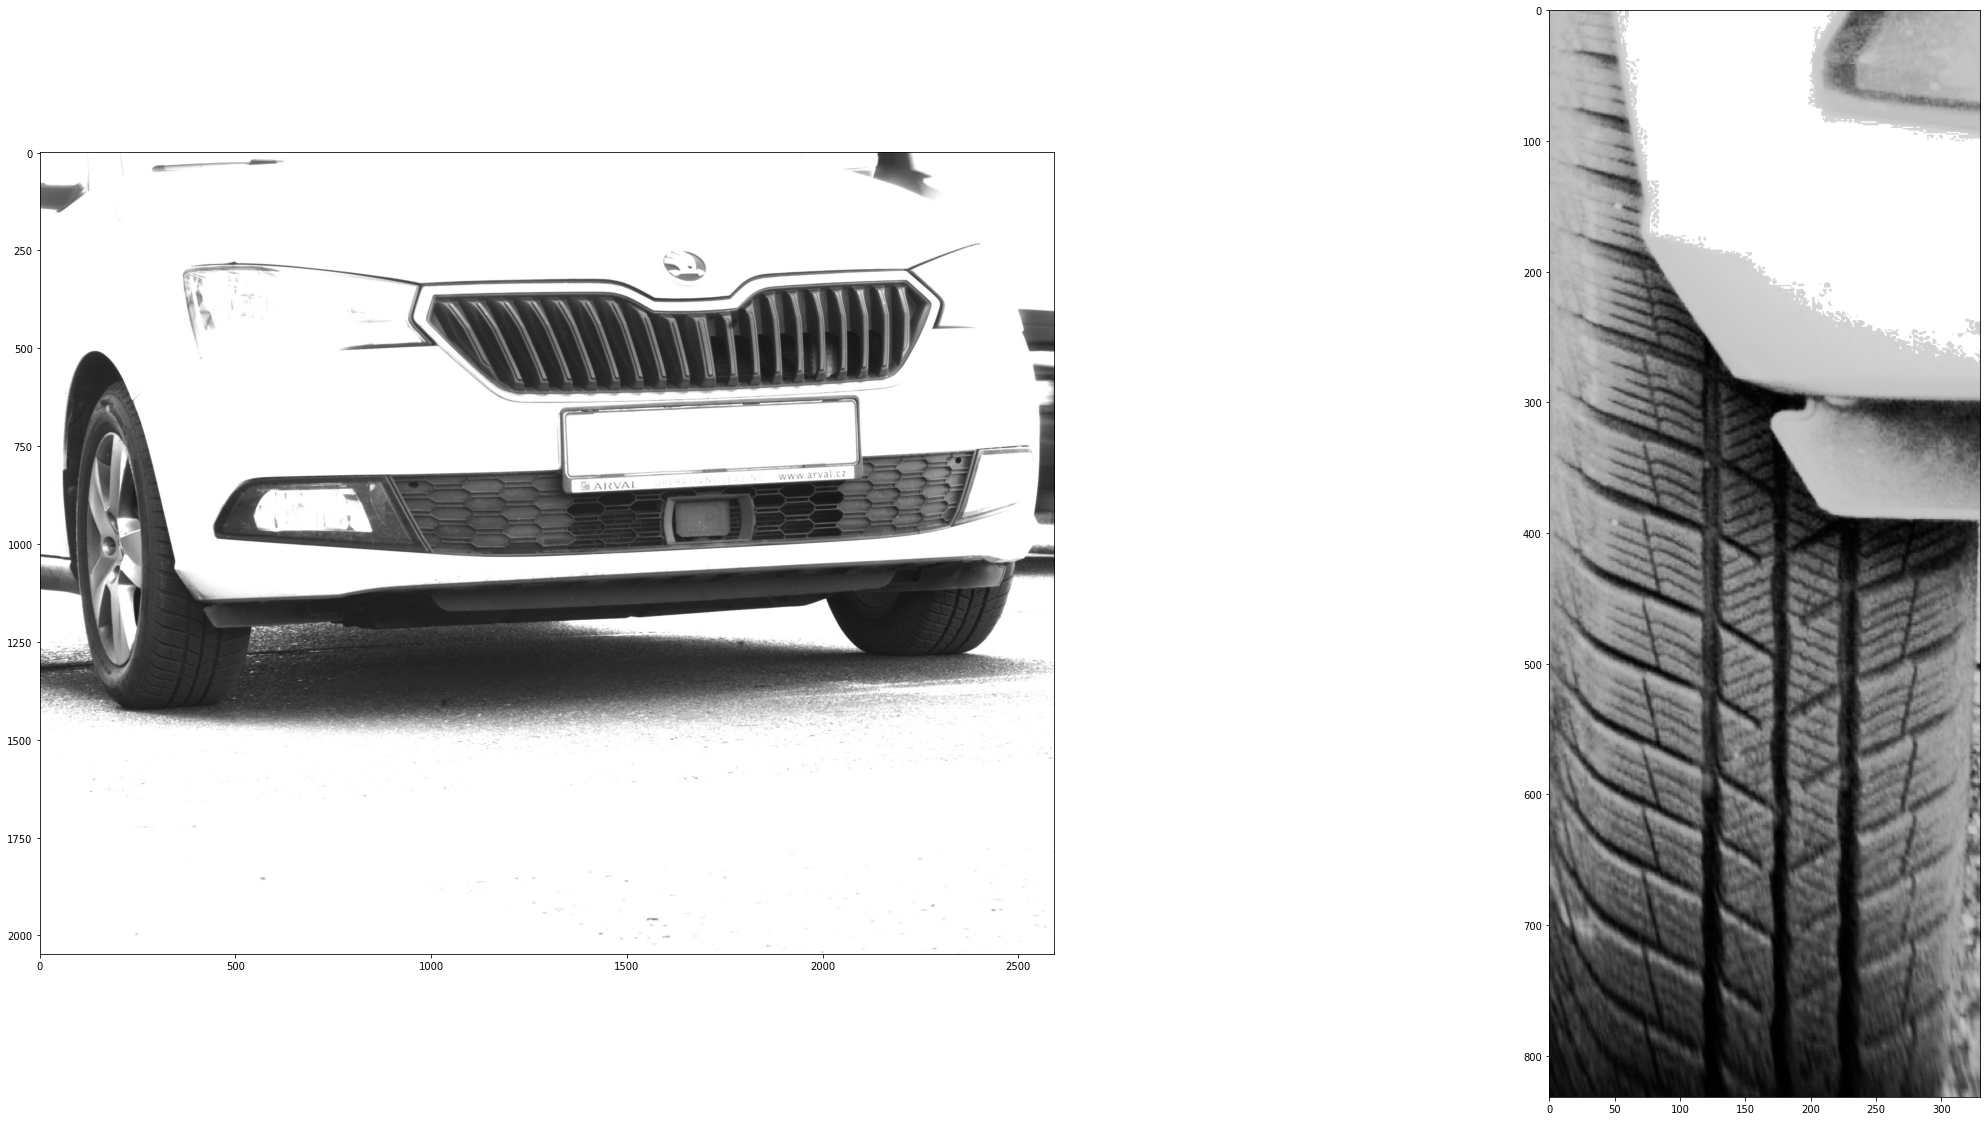

In [84]:
import treadscan as ts

# Load test image
image = test_images[4]

# Find keypoints
keypoints = predict(image)

if keypoints is not None:
    # Construct tire model
    top, bottom, right, sidewall, width = keypoints
    ellipse = ts.ellipse_from_points(top, bottom, right)
    sidewall = int(ts.euclidean_dist(top, sidewall))
    extractor = ts.Extractor(image, ellipse)
    bounding_ellipses = extractor.get_tire_bounding_ellipses(tire_sidewall=sidewall, tire_limit=width)
    
    # Extract tread
    tread = extractor.extract_tread(tire_bounding_ellipses=bounding_ellipses)
    
    # Display it
    tread = cv2.equalizeHist(tread)
    f, ax = plt.subplots(1, 2, figsize=(40, 20))
    ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_GRAY2RGB))
    ax[1].imshow(cv2.cvtColor(tread, cv2.COLOR_GRAY2RGB))
else:
    print('No tire found')

## 6.2 Feature maps

In [12]:
# Remove previos hook (useful when you're coming back to this cell)
if handle is not None:
    handle.remove()

# Clear list
feature_maps = []

def hook_feat_map(mod, inp, out):
    feature_maps.append(out)

# Register a hook to a given layer (layers are described in the output of the cell where model is loaded)
layer = 'rpn.head.conv'
handle = model.get_submodule(layer).register_forward_hook(hook_feat_map)

print(handle)

Confidence: 1.00


[[177, 712], [205, 1307], [259, 1019], [180, 592], [525, 1266]]

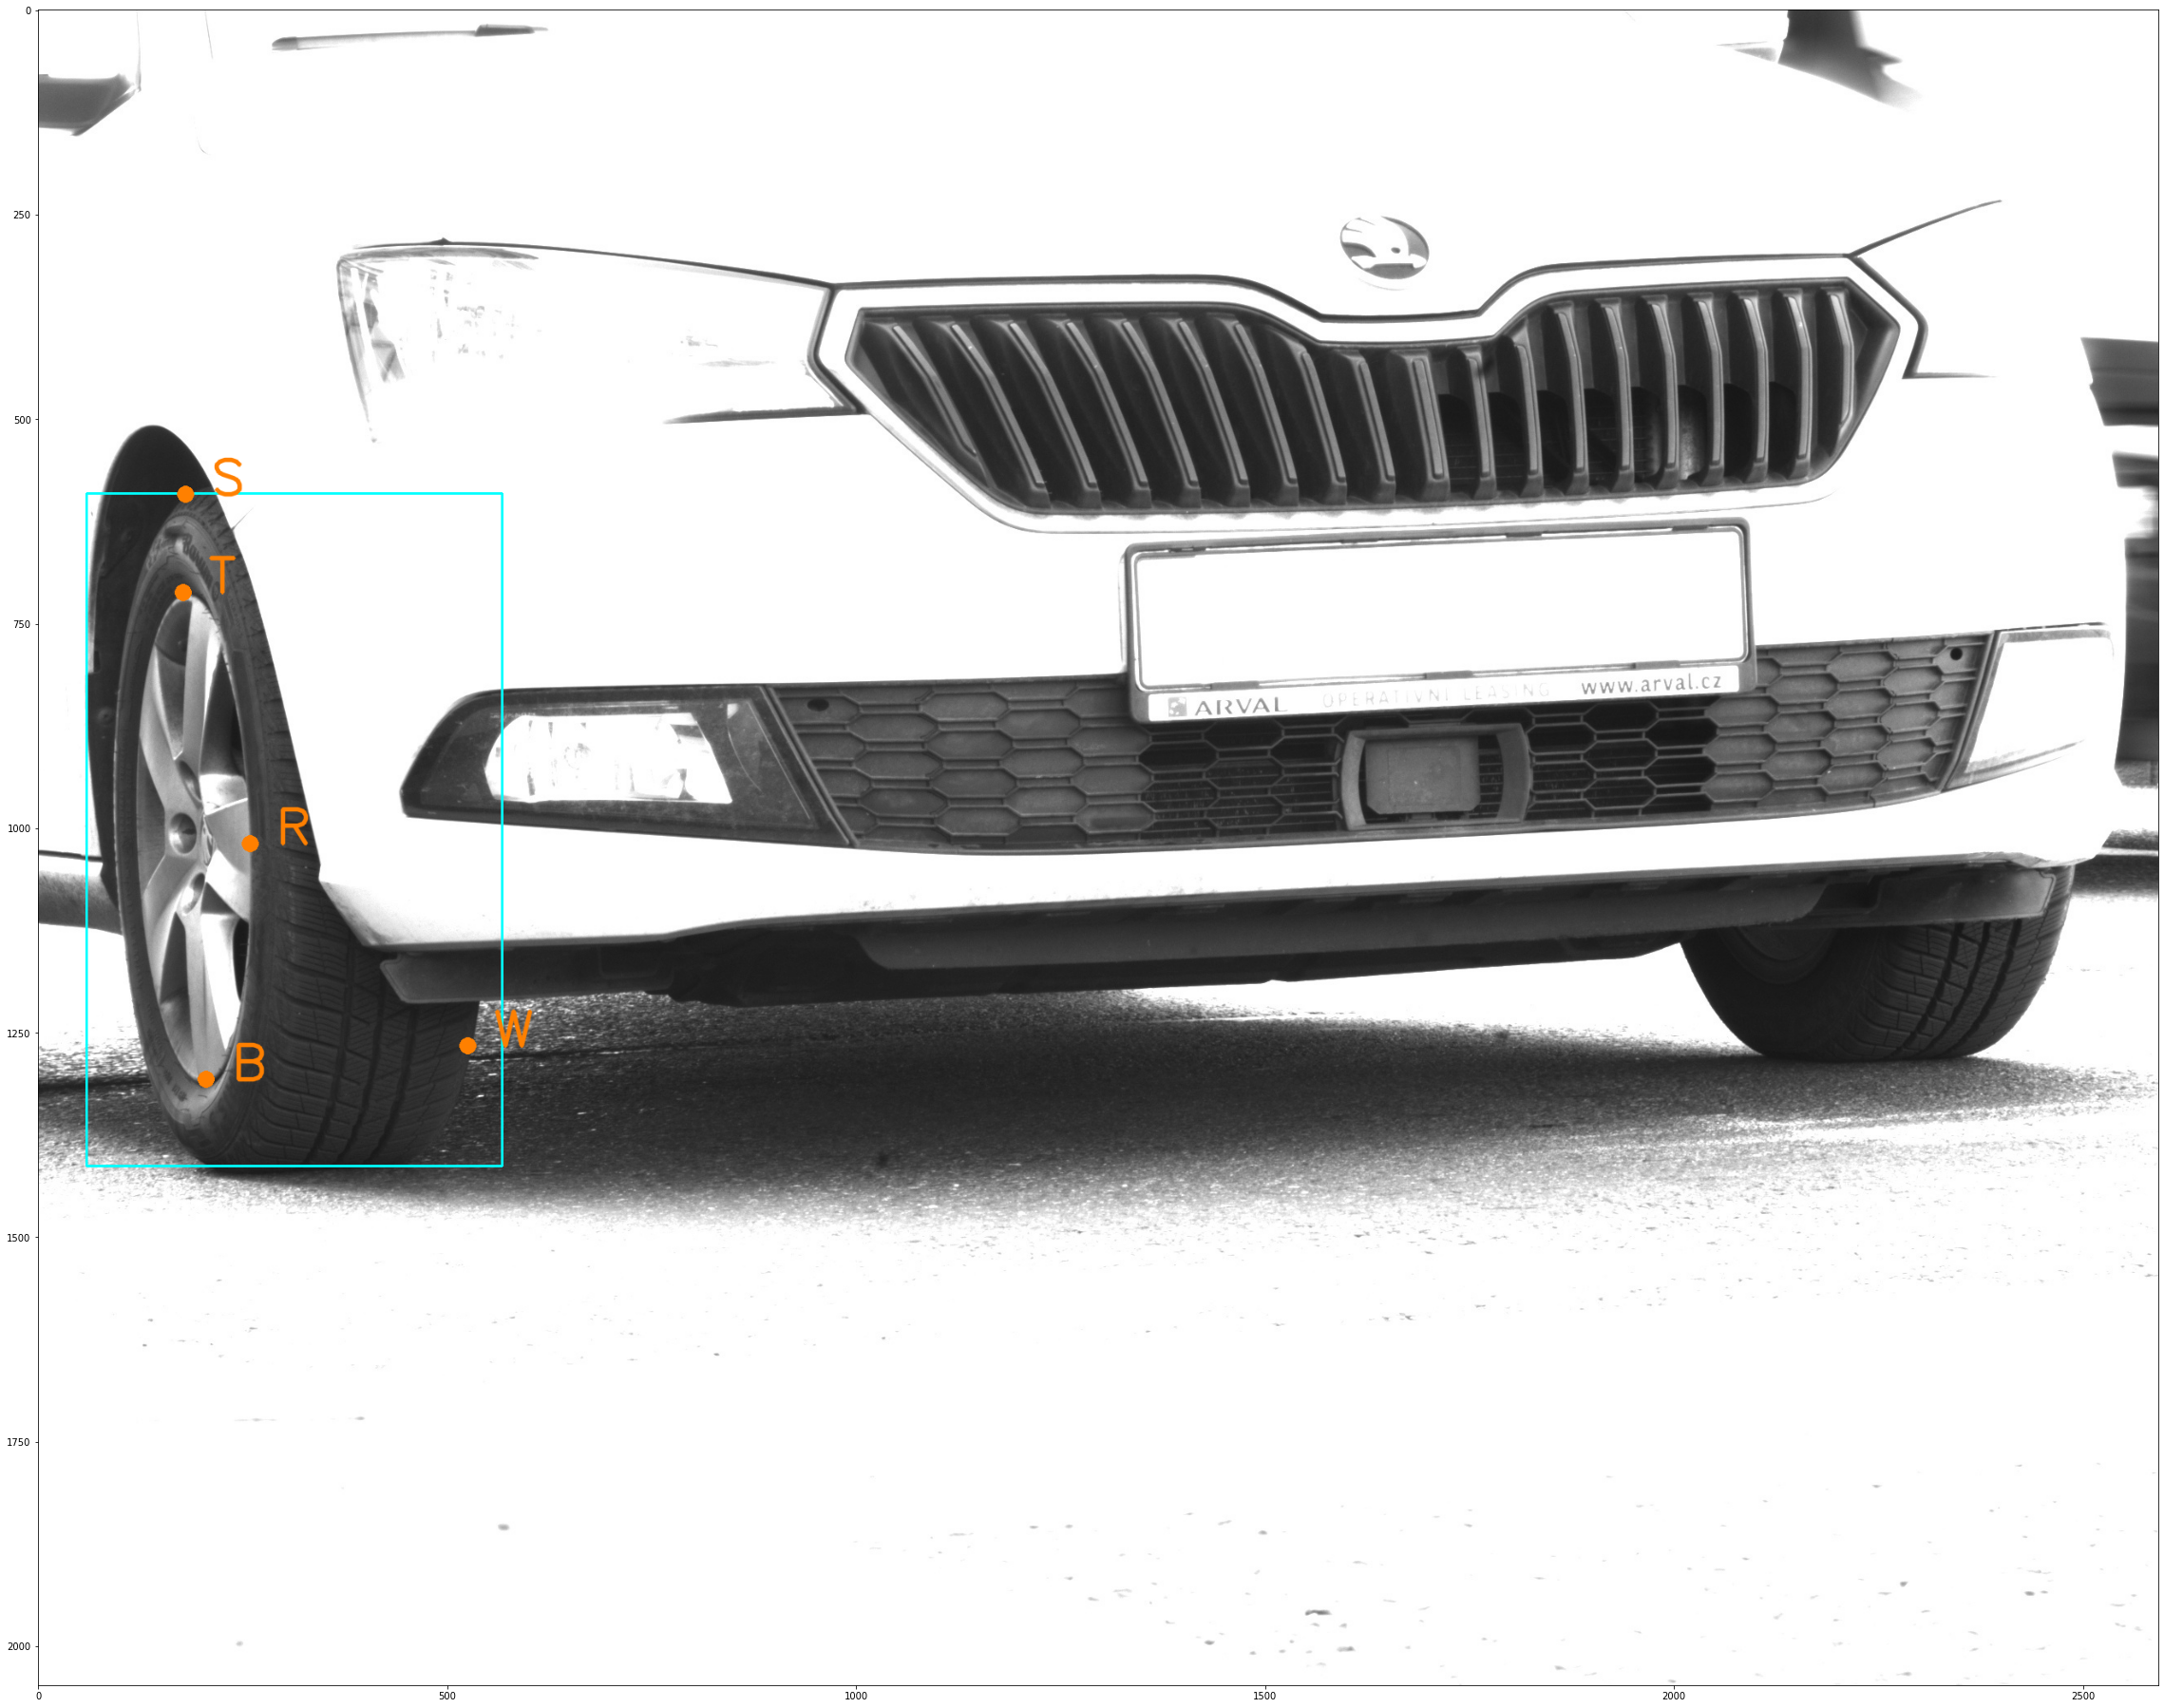

In [88]:
# Forward an image
predict(test_images[4], print_image=True)

In [14]:
# Analyze feature maps (some might be hidden behind an OrderdDict etc.), depending on the layer
print(len(feature_maps[0].detach().cpu().numpy()[0]))
print(feature_maps[0].detach().cpu().numpy()[0][0].shape)

256
(200, 256)


In [15]:
# Save all feature maps of this layer in a folder
folder = f'my_path/feature_maps/{layer}'

if not os.path.exists(folder):
    os.makedirs(folder)

i = 0
for feature_map in feature_maps[0].detach().cpu().numpy()[0]:
    # Convert float32 image to uint8
    feature_map = cv2.normalize(feature_map, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    # Save to disk
    cv2.imwrite(f'{folder}/{i}.jpg', feature_map)
    i += 1